In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R
suppressPackageStartupMessages({
  suppressMessages({
    library(data.table)
    library(dplyr)
    library(learnr)
    library(microbenchmark)
    library(parallel)
    library(parallelly)
    library(profvis)
    library(Rcpp)
    library(styler)
  })
})

# Acceleration via `Rcpp` (advanced)
## Overview
C++ is a high-performance, general-purpose programming language that extends C with object-oriented, generic, and functional programming features. If you don't know what those are, or have never used C++ before, do not worry. For us the most important point to note is that it can provide a **fast** alternative to R and can be integrated into our R code. In fact, under the hood, many of the base R functions are themselves written in C. In addition, many R packages on CRAN contain functions written in C++.

The easiest way to use C++ code in an R environment is through the Rcpp package. On MacOS and Linux systems, the Rcpp package is likely to be setup and loaded correctly after executing `install.packages('Rcpp')`, followed by `library(Rcpp)`. On a windows OS, you may need to follow the instructions [here](https://cran.r-project.org/bin/windows/Rtools/) to download Xtools. 

You can check `Rcpp` is set up correctly by trying the following:

In [25]:
%%R
evalCpp("2+2")

[1] 4


## Example: Estimating Pi
Suppose we want to estimate the value of pi. One way of doing this is to use Monte Carlo sampling.

Consider a quarter-circle of radius 1 inside the unit square \([0,1] \times [0,1]\). The equation for the quarter-circle is:

\[
x^2 + y^2 \leq 1
\]

Since the area of the full circle is \(\pi\), the quarter-circle has an area of \(\pi/4\). By randomly sampling points inside the square and checking how many fall inside the quarter-circle, we can estimate \(\pi\) using:

\[
\pi \approx 4 \times \frac{M}{N}
\]

where \(M\) is the number of points inside the quarter-circle, and \(N\) is the total number of points sampled.

We can plot this set-up:

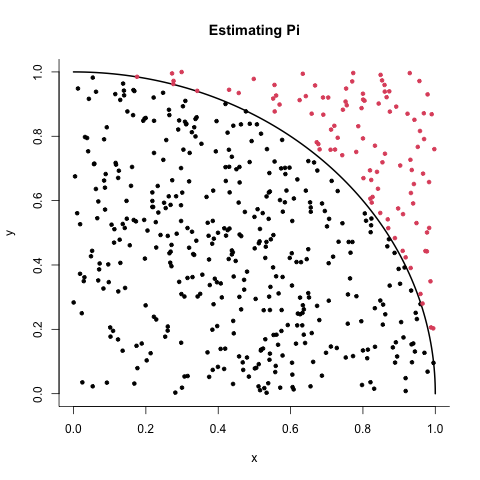

In [26]:
%%R
# Define the quarter-circle function
theta <- seq(0, pi/2, length.out = 100)
x <- cos(theta)
y <- sin(theta)

samps <- runif(1000) |>
  matrix(ncol = 2)

inside <- samps[sqrt(rowSums(samps^2)) < 1,]
outside <- samps[sqrt(rowSums(samps^2)) >= 1,]

# Plot the quarter-circle
plot(x, y, type = "l", lwd = 2, col = 1, xlim = c(0,1), ylim = c(0,1),
     xlab = "x", ylab = "y", main = "Estimating Pi",
     xpd = FALSE, bty='l')
points(x = inside[,1], y = inside[,2], pch = 20, col = 1)
points(x = outside[,1], y = outside[,2], pch = 20, col = 2)

An implementation of this procedure in R is as follows:

In [27]:
%%R
pi_R <- function(n) {
  
  # we want n points, each point is in 2D space, so we need to sample m = 2*n
  # points using runif()
  m <-  2*n
  
  # get m samples - each sample is a row of the matrix 
  samples <- runif(m) |>
    matrix(ncol = 2)
  
  # how many lie inside the quarter circle?
  # get the distance between each row and the origin (0,0)
  n_inside_circle <- sum(sqrt(rowSums(samples^2)) < 1)
  
  # estimate pi by multiplying the proportion of points inside the quarter
  # circle by 4
  pi_estimate <- (n_inside_circle/n) * 4
}

Now, we can run the function for increasing $n$, which should converge to the true value of $\pi$.

In [28]:
%%R
# Estimates for different n
pi_estimate_1 <- pi_R(1)
pi_estimate_10 <- pi_R(10)
pi_estimate_100 <- pi_R(100)
pi_estimate_1000 <- pi_R(1000)
pi_estimate_10000 <- pi_R(10000)

pi_vec <- c(pi_estimate_1,
            pi_estimate_10,
            pi_estimate_100,
            pi_estimate_1000,
            pi_estimate_10000)

print(pi_vec)

[1] 4.0000 3.2000 3.2400 3.1400 3.1156


We can also plot the estimates, and compare them to the value of $\pi$ contained in `R`, which is accessible through `pi` and is denoted by the dashed horizontal line.

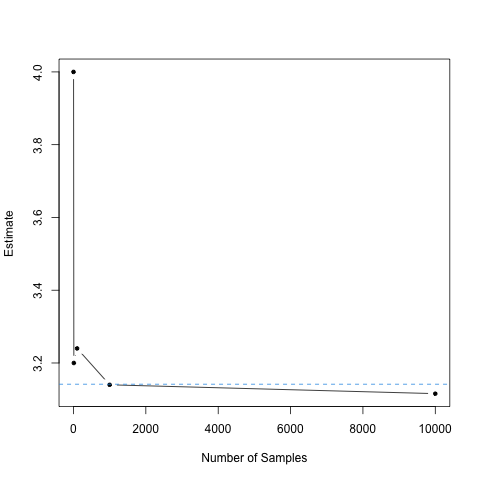

In [29]:
%%R
plot(c(1,10,100,1000, 10000), 
     pi_vec, 
     type ='b', 
     pch = 20,
     xlab = "Number of Samples",
     ylab = "Estimate")
abline(h = pi, col = 4, lty = 2)

Suppose we want to do the same in C++. We can write the C++ code in a seperate file with a `.cpp`, then call it within `R` using the `sourceCpp()` function provided in the `Rcpp` package. For completeness, the C++ source code contained in the file `pi.cpp` is as follows:

Loading the function into `R` is as simple as calling `sourceCpp()`:

In [30]:
%%R
sourceCpp("pi.cpp")

We can now run the function:

In [31]:
%%R
pi_cpp(10000)

[1] 3.146


Finally, let's compare it with the `R` implementation using `microbencmark`:

In [32]:
%%R
results <- microbenchmark(pi_R(1e6), pi_cpp(1e6))
summary(results)

           expr       min        lq      mean    median        uq      max
1   pi_R(1e+06) 13.592771 14.388253 15.274237 14.676278 14.971642 51.88784
2 pi_cpp(1e+06)  8.333004  8.383926  8.506798  8.414492  8.468386 10.27579
  neval
1   100
2   100


The `C++` version is about twice as fast as the `R` version using 1e6 samples.